In [1]:
import collections
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import random
import copy
import functools
from typing import Tuple

import game

In [2]:
#@title enumerating initial states with 4 players {vertical-output: true}

num_players = 4
%time states = game.all_possible_initial_states(num_players)
print(f'{states.shape[0]} initial states for {num_players} players')
print(f'Here\'s one:\n{states[np.random.randint(states.shape[0])]}')

CPU times: user 421 ms, sys: 26.2 ms, total: 447 ms
Wall time: 410 ms
10147 initial states for 4 players
Here's one:
[[0 1 0 3]
 [0 0 4 0]
 [1 3 0 0]
 [3 0 0 1]]


In [3]:
#@title enumerating initial states with 5 players {vertical-output: true}

num_players = 5
%time states = game.all_possible_initial_states(num_players)
print(f'{states.shape[0]} initial states for {num_players} players')
print(f'Here\'s one:\n{states[np.random.randint(states.shape[0])]}')

CPU times: user 1min 40s, sys: 1.63 s, total: 1min 41s
Wall time: 1min 39s
2224955 initial states for 5 players
Here's one:
[[1 2 0 1 0]
 [2 0 0 0 2]
 [0 0 2 0 2]
 [0 0 2 2 0]
 [1 2 0 1 0]]


In [6]:
#@title Shaking down that one state you sent me {vertical-output: true}

# 00022?x13
# 1??x0
# 2?x13
# 113??x0   <<<< next player

known = np.array([[3, 0, 0, 0],   # locations of known 0's
                  [0, 1, 0, 2],   # locations of known 1's
                  [2, 0, 1, 0],   # locations of known 2's
                  [0, 0, 0, 1]])  # locations of known 3's
unknown = np.array([1, 2, 1, 2])
is_excluded = np.zeros((4, 4), dtype=bool)
is_excluded[0, [1, 3]] = True  # players 1 and 3 aren't holding any 0's
is_excluded[1, [0, 2]] = True  # players 0 and 2 aren't holding any 1's
is_excluded[3, [0, 2]] = True  # players 0 and 2 aren't holding any 3's

pos = game.Position(curr_player=3, known=known, unknown=unknown, is_excluded=is_excluded)
%time states = pos.states
print(pos)
print(f'all states consistent with data:\n{states}')

CPU times: user 1.37 ms, sys: 0 ns, total: 1.37 ms
Wall time: 1.24 ms
   known   unknown  (4 possibilities) 36494450566594931502797524
0: 00022   ?{02}      
1: 13      ?{13}      
2: 2       ?{02}      
3: 1133    ?{13}      < current
all states consistent with data:
[[[3 0 1 0]
  [0 1 0 3]
  [3 0 1 0]
  [0 2 0 2]]

 [[3 0 1 0]
  [0 2 0 2]
  [3 0 1 0]
  [0 1 0 3]]

 [[4 0 0 0]
  [0 1 0 3]
  [2 0 2 0]
  [0 2 0 2]]

 [[4 0 0 0]
  [0 2 0 2]
  [2 0 2 0]
  [0 1 0 3]]]


# Work in progress

In [7]:
NUM_PLAYERS = 3
states = game.all_possible_initial_states(NUM_PLAYERS)
pos = game.Position(states=states)
print(pos)

   known   unknown  (120 possibilities) 1196035
0:         ????{012}  < current
1:         ????{012}  
2:         ????{012}  


In [8]:
# pos = Position(curr_player, active_player, requested_suit, states, known, unknown, is_excluded)

num_states = [len(pos.states)]

print(pos)
win = game.winner(pos)

while True:
# for _ in range(4):
  if win is not None:
    break

  moves = game.legal_moves(pos)
  if False:
    print(list(enumerate(moves)))
    move_num = int(input('Which one?'))
    move = moves[move_num]
  else:
    move_num = np.random.randint(len(moves))
    move = moves[move_num]
    if isinstance(move, game.Answer):
      print(move)

  pos = game.do_move(pos, move)
  win = game.winner(pos)
  num_states.append(len(pos.states))
  print(pos)

print(win, 'wins')

   known   unknown  (120 possibilities) 1196035
0:         ????{012}  < current
1:         ????{012}  
2:         ????{012}  
   known   unknown  (85 possibilities) 2533343510806531
0: 1       ???{012}   < current
1:         ????{012}  
2:         ????{012}  < got a 1?
Answer(give_card=True)
   known   unknown  (55 possibilities) 5629636974096387
0: 11      ???{012}   
1:         ????{012}  < current
2:         ???{012}   
   known   unknown  (30 possibilities) 7037020447551491
0: 11      ???{012}   
1: 1       ???{012}   < current
2:         ???{012}   < got a 1?
Answer(give_card=False)
   known   unknown  (20 possibilities) 11259145098211395
0: 11      ???{012}   
1: 1       ???{012}   
2:         ???{02}    < current
   known   unknown  (16 possibilities) 10133794947178563
0: 11      ???{012}   
1: 1       ???{012}   < got a 0?
2: 0       ??{02}     < current
Answer(give_card=False)
   known   unknown  (5 possibilities) 35880190911555
0: 011     ??{012}    < current
1: 122     ?{12}

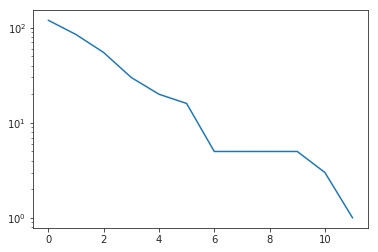

In [9]:
plt.plot(num_states)
plt.yscale('log')

In [10]:
DRAW = NUM_PLAYERS
OUTCOMES = tuple(list(range(NUM_PLAYERS)) + [DRAW])
OUTCOME_STR = [f'{p} wins' for p in range(NUM_PLAYERS)] + ['draw']

def to_dist(outcome_or_list):
  if isinstance(outcome_or_list, int):
    return tuple(1 if o == outcome_or_list else 0 for o in OUTCOMES)
  else:
    return tuple(np.mean([to_dist(o) for o in outcome_or_list], axis=0))

def value_fn(me, dist):
  prefs = (me, me + 1, me + 2)
  base = 2
  for p in prefs:
    val = dist[p % NUM_PLAYERS]
    if val > 0:
      return base + val
    base -= 1
  return base + 1

def value_fn(me, dist):
  if dist[me] > 0:
    return dist[me] + 1
  elif dist[DRAW] > 0:
    return dist[DRAW]
  else:
    return 0
VALUE_FN = {
    0: functools.partial(value_fn, 0),
    1: functools.partial(value_fn, 1),
    2: functools.partial(value_fn, 2),
}
MAX_VALUE = {k: max(v(to_dist(o)) for o in OUTCOMES) for k, v in VALUE_FN.items()}
MIN_VALUE = {k: min(v(to_dist(o)) for o in OUTCOMES) for k, v in VALUE_FN.items()}

In [11]:
for i in range(NUM_PLAYERS):
  s = ', '.join([f'{OUTCOME_STR[o]}:{VALUE_FN[i](to_dist(o))}' for o in OUTCOMES])
  print(f'{i}: {s}')

0: 0 wins:2, 1 wins:0, 2 wins:0, draw:1
1: 0 wins:0, 1 wins:2, 2 wins:0, draw:1
2: 0 wins:0, 1 wins:0, 2 wins:2, draw:1


In [17]:
best_moves = dict() 
parents = collections.defaultdict(set)  # for unresolved states, keep track of who to update once you're updated
lb_value = collections.defaultdict(lambda: -100)
ub_value = collections.defaultdict(lambda: 100)
possible_dists = collections.defaultdict(lambda: tuple(to_dist(o) for o in OUTCOMES))

last_update_time = time.perf_counter()
stack_depth = []
num_states = []

def dists(pos, stack=[], verbose=False) -> Tuple[Tuple, bool]:
  if verbose:
    print(f'#### at depth {len(stack)}, {lb_value[pos.packed]}<= value <={ub_value[pos.packed]}\n{pos}')
    possible = possible_dists[pos.packed]
    print(f'initial possible dists: {possible}')
    _ = input('')
  resolved = (lb_value[pos.packed] == ub_value[pos.packed])
  if not resolved:
    update(pos, stack, verbose)
    resolved = (lb_value[pos.packed] == ub_value[pos.packed])
  possible = possible_dists[pos.packed]
  if verbose:
    print(f'{pos}\nreturning {possible}, {resolved}')
  return possible, resolved

def update(pos, stack=[], verbose=False):

  stack_depth.append(len(stack))

  me = pos.active_player  # this is the player making a move from this position

  win = game.winner(pos)
  if win is not None:
    value = VALUE_FN[me](to_dist(win))
    if verbose:
      print(f'setting bounds to {value} for outcome {OUTCOME_STR[win]}')
    possible_dists[pos.packed] = (to_dist(win),)
    lb_value[pos.packed] = value
    ub_value[pos.packed] = value
    return

  # For each of my possible moves, determine the outcome if I make that move.
  best_next, worst_next = [], []
  resolved_all_children = True
  moves = game.legal_moves(pos)
  next_positions = [game.do_move(pos, move) for move in moves]
  seen_dists = set()
  # Try moves which reduce the number of states first.
  idx = np.argsort([len(p.states) for p in next_positions])
  if verbose:
    print(f'Options: {[(moves[i], len(next_positions[i].states)) for i in idx]}')
  for i in idx:
    next_position = next_positions[i]
    move = moves[i]
    if next_position.packed in stack:
      if verbose:
        print(f'{move} would lead to repeat position {next_position.packed}; skipping')
      best_next.append(max(VALUE_FN[me](d) for d in possible_dists[next_position.packed]))
      worst_next.append(min(VALUE_FN[me](d) for d in possible_dists[next_position.packed]))
      seen_dists |= set(possible_dists[next_position.packed])
      # Record that when the next position gets worked out, we should come back
      # and re-evaluate to this one.
      parents[next_position.packed].add(pos.packed)
      resolved_all_children = False
      continue

    stack.append(next_position.packed)
    # print(f'trying {stack[-1]}, stack size {len(stack)}')
    if verbose:
      print(f'trying {move}')
    next_dists, next_resolved = dists(next_position, stack, verbose)  # rely depth-first search and cache
    seen_dists |= set(next_dists)
    stack.pop()

    # WARNING: This assumes that the value of a distribution is
    # *some* convex combination of its support. e.g. you can't assign higher
    # value to a distribution than to any of the outcomes where it's nonzero.
    if next_resolved:
      # Next player values all these distributions the same, and I assume they'll
      # choose randomly between them. Note that this is not the same as choosing
      # randomly among *moves* which lead to those distributions.
      mean_dist = tuple(np.mean(next_dists, axis=0))
      seen_dists.add(mean_dist)
      value = VALUE_FN[me](mean_dist)
      best_next.append(value)
      worst_next.append(value)
    else:
      best_next.append(max(VALUE_FN[me](d) for d in next_dists))
      worst_next.append(min(VALUE_FN[me](d) for d in next_dists))
    if verbose:
      print(f'back up to stack depth {len(stack)}')
      print(f'{worst_next[-1]} <= next_value <= {best_next[-1]}')
    if worst_next[-1] == MAX_VALUE[me]:
      # I can force my preferred outcome. No need to search further.
      break

  low_bound = max([lb_value[pos.packed]] + worst_next)  # I can force at least this value
  high_bound = max([lb_value[pos.packed]] + best_next)  # I *may* be able to force this value

  if verbose:
    print(f'Explored options {list(zip(moves, worst_next, best_next))}')
    print(f'resolved_all_children {resolved_all_children}')
    print(f'Saw dists {seen_dists}')
  lb_value[pos.packed] = low_bound
  # if resolved_all_children or lb_value[pos.packed] == MAX_VALUE[me]:
  #   # Note: if not all children were resolved, I may be able to force an even
  #   # better outcome, so don't update ub_value.
  ub_value[pos.packed] = high_bound
  possible_dists[pos.packed] = tuple(d for d in seen_dists if lb_value[pos.packed] <= VALUE_FN[me](d) <= ub_value[pos.packed])

In [49]:
# pos = Position(curr_player, active_player, requested_suit, states, known, unknown, is_excluded)
pos = game.Position(states=game.all_possible_initial_states(NUM_PLAYERS))
# pos = game.Position(packed=5137064387978307)
print(pos)

   known   unknown  (120 possibilities) 1196035
0:         ????{012}  < current
1:         ????{012}  
2:         ????{012}  


In [51]:
%%time
stack = []
o = dists(pos, stack, verbose=False)
print(o)

(((0.4375, 0.3125, 0.25, 0.0),), True)
CPU times: user 161 µs, sys: 3 µs, total: 164 µs
Wall time: 124 µs


In [52]:
len(lb_value), len(ub_value), len(parents)

(129721, 129721, 252)

In [53]:
lb_value[pos.packed], ub_value[pos.packed]

(1.4375, 1.4375)

In [32]:
prev_num_parents = 0
num_resolved = 0
while num_resolved > 0 or len(parents) != prev_num_parents:
  num_resolved = 0
  prev_num_parents = len(parents)
  for p in list(parents.keys()):
    for parent in list(parents[p]):
      dists(game.Position(packed=parent))
    ds, resolved = dists(game.Position(packed=p))
    if resolved:
      num_resolved += 1
      del parents[p]
  print(num_resolved, len(parents))

36 252
0 252


In [33]:
# If a draw is possible from a parent position, it's required. Is this true?
num_resolved = 0
for p in list(parents.keys()):
  draw_dist = to_dist(DRAW)
  if draw_dist in possible_dists[p]:
    num_resolved += 1
    possible_dists[p] = (draw_dist,)
    pos = game.Position(packed=p)
    lb_value[p] = VALUE_FN[pos.active_player](draw_dist)
    ub_value[p] = VALUE_FN[pos.active_player](draw_dist)
    del parents[p]
print(num_resolved)

0


In [0]:
# If a draw is not possible and we're not getting anywhere, assume each move
# will resolve to the average of possible distributions
packed_pos = list(parents.keys())[0]
position = game.Position(packed=packed_pos)
moves = legal_moves(position)
next_positions = [game.do_move(position, move) for move in moves]
best_ds, best_value = [], MIN_VALUE[position.active_player]
for m, p in zip(moves, next_positions):
  ds, resolved = dists(p)
  d = tuple(np.mean(ds, axis=0))
  value = VALUE_FN[position.active_player](d)
  if value > best_value:
    best_value = value
    best_ds = [d]
  elif value == best_value:
    best_ds.append(d)

possible_dists[packed_pos] = (tuple(np.mean(best_ds, axis=0)),)
lb_value[packed_pos] = value
ub_value[packed_pos] = value

In [25]:
packed_pos = list(parents.keys())[0]
# packed_pos = 1131475061998096
# packed_pos = 1245828121360
position = game.Position(packed=packed_pos)
print(position)
move = None
print(position.packed)
print(lb_value[position.packed], ub_value[position.packed], possible_dists[position.packed])

IndexError: list index out of range

In [54]:
dists(position)

(((0.4375, 0.3125, 0.25, 0.0),), True)

In [55]:
position = game.Position(states=game.all_possible_initial_states(NUM_PLAYERS))
move = None
print(position)

   known   unknown  (120 possibilities) 1196035
0:         ????{012}  < current
1:         ????{012}  
2:         ????{012}  


In [70]:
if move:
  position = game.do_move(position, move)
  move = None

print(position)
win = game.winner(position)
if win is not None:
  raise ValueError(f'game over: {OUTCOME_STR[win]}')

moves = game.legal_moves(position)
next_positions = [game.do_move(position, move) for move in moves]
best_moves, best_value = [], MIN_VALUE[position.active_player]
for m, p in zip(moves, next_positions):
  ds, resolved = dists(p)
  if not resolved:
    raise ValueError(p.packed)
  d = tuple(np.mean(ds, axis=0))
  value = VALUE_FN[position.active_player](d)
  print(m, ds, value)
  if value > best_value:
    best_value = value
    best_moves = [m]
  elif value == best_value:
    best_moves.append(m)

if moves:
  move = random.choice(best_moves)
  print(f'an optimal move: {move} {best_value}')

   known   unknown  (1 possibilities) 5704910578385011
0: 001                
1: 0111               < current
2: 02222              


ValueError: game over: 0 wins

In [0]:
move = game.Ask(player=2, suit=0)
# move = game.Answer(False)